Agenda
- 各自讲讲模型部分（怎么建的、有啥问题）
- 一起讨论大的目标


TODO
- all: 顺着大方向，作一些调整，补充markdown解释
- jinming: try implict ALS CF Model. Use MAE?
- leyi: 加roc-based metrics, evaluate model 2

ps: 避免漏掉修改，两个人合一份，最后再把两份整合到一起

# 1. Business Objectives

Imagine that you work for a digital media company that needs to recommend movies. What is your objective? What are you trying to optimizing and what are you willing to sacrifice? 

State your business objectives in building a recommendation system. Indicate

- Objective function: state your business objective, and how this would translate to the metrics that you will ultimately be optimizing for	 	 	 		
- Any metric you wish to optimize in addition to accuracy 
- The intended user （active users with certain amount of rating records）
- Any business rules you think will be important  （推荐内容的种类多样性？不重复性？但比较复杂，这次作业可能暂时实现不出来）
- Performance requirements (time and/or complexity) （训练和预测时间要可接受，支持每天更新，支持大样本）
- And more (for example: interpretability, diversity, novelty, etc) 		

初步想法：

目标：首页推荐TOP K电影给每个用户

实现：训练模型（min mae） -> 推荐电影给用户（max recall/auc, user_coverage)

- Based on the movie-rating historical data, we are to provide personalizied lists of movies specific to active user, in section like "TOP 10 MOVIES THAT YOU MAY ALSO LIKE" in the APP.

- To goal is to make good recommendations to active users, in order to increase the chance of them clicking into, watching and liking one of the recommended movies. 

- Therefore, while maximizing rating accuracy for model training, our ultimate goal is to improve recall/AUC and user-coverage: the higher these metrics are, the better job we are doing in making well recommendations to active users. 

- To achieve this goal, we will limit our training set to only include movies and users with certain number of rating records, so that we could achieve better overall accuracy thus giving better recommendations. 

- Inevitably, this will limit the system's performance in cold-start recommendations to some extent but this is acceptable under this overall objective. So we might care less on metrics like movie-coverage, catalog-coverage.

reco func可能要完善一下：推荐之前没看过的（就是没在train set里的）。更严格来讲，应该推荐某个日期之后的。但实现起来可能比较复杂。

# 2. Model Exploration & Evaluation 

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from item_based_cf_v3 import *
from metrics_helper_v4 import *

In [2]:
df = pd.read_csv('./ml-latest/ratings.csv')
df.drop("timestamp", inplace=True, axis=1)

In [24]:
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
n_ratings = len(df)
sparsity = round(1.0-len(df)/float(n_users*n_items),5)
print(f'The number of unique users is {n_users}')
print(f'The number of unique items is {n_items}')
print(f'The number of ratings provided is {n_ratings}')
print(f'The sparsity is {sparsity*100}%')

The number of unique users is 283228
The number of unique items is 53889
The number of ratings provided is 27753444
The sparsity is 99.818%


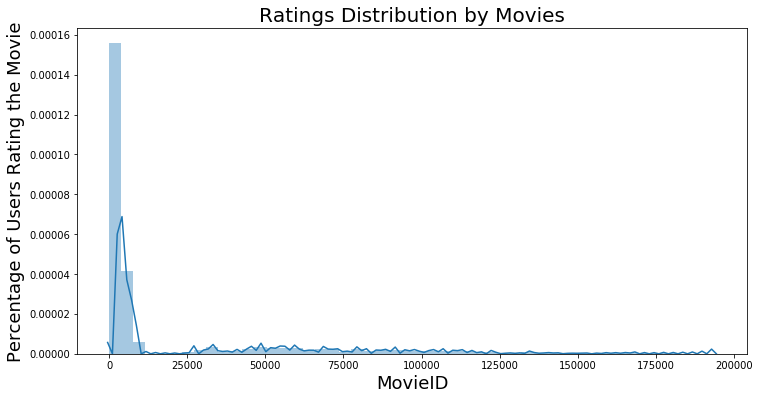

In [25]:
# rating distribution by movies
fig, ax = plt.subplots(figsize=(12,6))
fig = sns.distplot(df['movieId'])
ax.set_ylabel('Percentage of Users Rating the Movie', size=18)
ax.set_xlabel('MovieID', size=18)
ax.set_title('Rating Distribution by Movies', size=20)
plt.show()

(cover movies of all popularity level: set some lower threshold for movies, like only include movies with greater than 5 or 100 ratings, but I wouldn't select only the most popular movies.

If you include all levels of popularity it would be great to subset your accuracy results by popularity. Do you see a curve in accuracy from least to most popular?

sample from sampled dataset)


## 2.1 Memory-based Collaborative Filtering

### 2.1.1 Data preprocessing

In [3]:
# stratified sampling by popuparity(rating counts)
df_sample = stratify_sample(df, 30)
# 20631 user, 150 items, 32685 records

### 2.1.2 Model Training 

In [21]:
# model1 = ItemBasedCF(3, 'pearson')

In [ ]:
# start = time.time()
# model1.fit(train_set, 1)
# end = time.time()
# print(f'training_time in seconds: {end-start}')

In [23]:
# model1.score(train_set, test_set)
# pre = model1.predict()

0.6849467997787729

In [4]:
from surprise import Dataset, Reader
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise import accuracy

In [82]:
from surprise.model_selection import train_test_split
reader = Reader(rating_scale = (0,5))
data = Dataset.load_from_df(df_sample[['userId', 'movieId', 'rating']], reader)
data_train, data_test = train_test_split(data, test_size = 0.2)

In [83]:
algo = KNNWithMeans(k=3, sim_options = {'name' : 'pearson', 'user_based' : False}, verbose = False)

In [84]:
start = time.time()
algo.fit(data_train)
pre = algo.test(data_test)
end = time.time()
print(f'training_time in seconds: {end-start}')

training_time in seconds: 0.11994338035583496


In [9]:
accuracy.mae(pre)

MAE:  0.7753


0.7752929806365989

### 2.1.3 Model Tuning with Cross validation

For every user you can remove k items (either random or most recent) from the training set and put them into the test set. 

In [9]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

In [10]:
# parameters = {'similarity_metrics':['pearson','cosine'], 'k_neighbors':np.arange(10,40,5)}
# model_test = ItemBasedCF()
# gs = GridSearchCV(model_test, parameters, cv=3)
# gs.fit(df_sample, df_sample)

LEYI: Reasons to use MAE:

One large characteristic of Mean Average Error(MAE) does not give any bias to extrema in error terms. If there are outliers or large error terms, it will weigh those equally to the other predictions. Therefore, MAE should be preferred when looking toward rating accuracy when you’re not really looking toward the importance of outliers. To get a holistic view or representation of the Recommender System, use MAE.

https://towardsdatascience.com/evaluating-recommender-systems-root-means-squared-error-or-mean-absolute-error-1744abc2beac

In [10]:
from surprise.model_selection import GridSearchCV

In [11]:
param_grid = {'sim_options':{'name': ['pearson','cosine'], 'user_based': [False]},
              'k': np.arange(30,40,5)
             }

In [15]:
gs = GridSearchCV(KNNWithMeans, param_grid, measures = ['rmse', 'mae'], cv=3)

In [16]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_sample, test_size=0.2)
train_df = Dataset.load_from_df(train_set[['userId', 'movieId', 'rating']], reader)

In [17]:
start = time.time()
gs.fit(train_df)
end = time.time()
print(f'training_time in seconds: {end-start}')

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
training_time in seconds: 1110.8477551937103


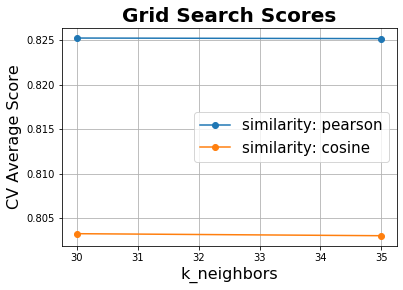

In [65]:
plot_grid_search(gs.cv_results['mean_test_mae'], param_grid['k'], param_grid['sim_options']['name'], 'k_neighbors', 'similarity')


In [55]:
print(gs.best_params['mae'])

{'sim_options': {'name': 'cosine', 'user_based': True}, 'k': 35}


In [56]:
print(gs.best_score['mae'])

0.8030630509045187


- We finally choose KNN model with k=xxx using xxx as similarity measure, because it gives the best mae score (0.xxx) from the validation set on average.

### 2.1.4 Model Evaluation

How do the evaluation metrics change as a function of your model size? Systematically change your data set size by again sampling your data from a small size to a large size (25%, 50%, 75%, 100%):
1. Does overall accuracy change?
2. What about the distribution of accuracy over users or items?
3. How does run-time scale with data size?

distribution of error, or the ranking metric, over users. You can report this as confidence intervals or ranges, or you can show the distributions with box plots or violin plots.

In [24]:
#TODO: ADD PLOTS TO answer:
#How does the evauation metrics change as sample size changes? like 25%, 50%, 75%, 100%
#How does the training and testing runtime change as sample size changes? like 25%, 50%, 75%, 100%

#### (1) Accuracy on training and test data

##### error-based accuracy

In [220]:
algo = KNNWithMeans(k=3, sim_options = {'name' : 'pearson', 'user_based' : False}, verbose = False)
algo.fit(data_train)

In [217]:
# MAE on test set
pre = algo.test(data_test)
accuracy.mae(pre)

MAE:  0.2201


0.22006334085823

In [221]:
from surprise.model_selection import train_test_split

algo = KNNWithMeans(k=3, sim_options = {'name' : 'pearson', 'user_based' : False}, verbose = False)
frac = [0.25, 0.5, 0.75, 1]
mae = []
for i in frac:
    subsampled_df = df_sample.sample(frac = i)
    subsampled_df = Dataset.load_from_df(subsampled_df[['userId', 'movieId', 'rating']], reader)
    subsampled_train, subsampled_test = train_test_split(subsampled_df, test_size = 0.2)
    algo.fit(subsampled_train)
    pre = algo.test(subsampled_test)
    mae.append(accuracy.mae(pre))

MAE:  0.6256
MAE:  0.5022
MAE:  0.3576
MAE:  0.2202


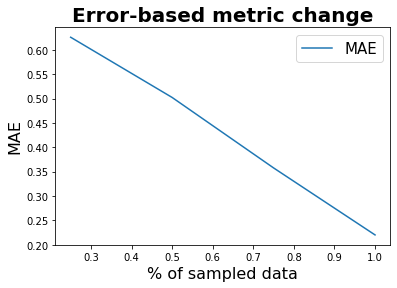

In [258]:
_, ax = plt.subplots(1,1)
ax.plot(frac, mae, label = 'MAE')
ax.set_title("Error-based metric change", fontsize=20, fontweight='bold')
ax.set_xlabel('% of sampled data', fontsize=16)
ax.set_ylabel('MAE', fontsize=16)
ax.legend(loc="best", fontsize=15)
plt.show()

##### ranking-based accuracy

In [208]:
test_df = pd.DataFrame(map(lambda x: {'user_id': x[0], 'item_id': x[1], 'real_rating': x[2]}, pre)).pivot(index='item_id', columns='user_id', values='real_rating').values
pred_df = pd.DataFrame(map(lambda x: {'user_id': x[0], 'item_id': x[1], 'est_rating': np.nan if x[4]['was_impossible'] == True else x[3]}, pre)).pivot(index='item_id', columns='user_id', values='est_rating').values

In [248]:
dcg(test_df, pred_df)

18.744596048929626

In [249]:
ndcg(test_df, pred_df)

0.6612007649048929

In [261]:
from surprise.model_selection import train_test_split

algo = KNNWithMeans(k=3, sim_options = {'name' : 'pearson', 'user_based' : False}, verbose = False)
frac = [0.25, 0.5, 0.75, 1]
dcg_score = []
ndcg_score = []

for i in frac:
    subsampled_df = df_sample.sample(frac = i)
    subsampled_df = Dataset.load_from_df(subsampled_df[['userId', 'movieId', 'rating']], reader)
    subsampled_train, subsampled_test = train_test_split(subsampled_df, test_size = 0.2)
    algo.fit(subsampled_train)
    pre = algo.test(subsampled_test)
    test_df = pd.DataFrame(map(lambda x: {'user_id': x[0], 'item_id': x[1], 'real_rating': x[2]}, pre)).pivot(index='item_id', columns='user_id', values='real_rating').values
    pred_df = pd.DataFrame(map(lambda x: {'user_id': x[0], 'item_id': x[1], 'est_rating': np.nan if x[4]['was_impossible'] == True else x[3]}, pre)).pivot(index='item_id', columns='user_id', values='est_rating').values
    dcg_score.append(dcg(test_df, pred_df))
    ndcg_score.append(ndcg(test_df, pred_df))

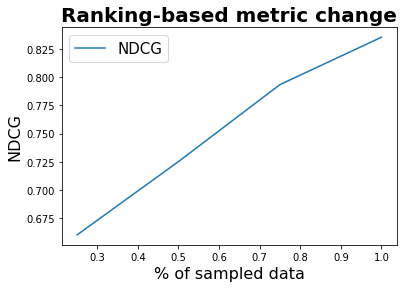

In [262]:
_, ax = plt.subplots(1,1)
ax.plot(frac, ndcg_score, label = 'NDCG')
ax.set_title("Ranking-based metric change", fontsize=20, fontweight='bold')
ax.set_xlabel('% of sampled data', fontsize=16)
ax.set_ylabel('NDCG', fontsize=16)
ax.legend(loc="best", fontsize=15)
plt.show()

#### (2) Coverage

In [215]:
# user_coverage: the fraction of users for which at least k items can be recommended well
user_coverage = cal_coverage(test_df, pred_df, threshold=3, coverage_type = 'user')
print('user coverage:', user_coverage)

# item_coverage: the fraction of items that can be recommended to at least k users well
item_coverage = cal_coverage(test_df, pred_df, threshold=3, coverage_type = 'item')
print('item coverage:', item_coverage)

# catalog_coverage: the fraction of items that are in the top-k for at least 1 user
catalog_coverage = cal_coverage(test_df, pred_df, coverage_type = 'catalog')
print('catalog coverage:', catalog_coverage)

user coverage: 1.0
item coverage: 0.4563106796116505
catalog coverage: 0.7669902912621359


In [260]:
from surprise.model_selection import train_test_split

algo = KNNWithMeans(k=3, sim_options = {'name' : 'pearson', 'user_based' : False}, verbose = False)
frac = [0.25, 0.5, 0.75, 1]
user_coverage = []
item_coverage = []
catalog_coverage = []

for i in frac:
    subsampled_df = df_sample.sample(frac = i)
    subsampled_df = Dataset.load_from_df(subsampled_df[['userId', 'movieId', 'rating']], reader)
    subsampled_train, subsampled_test = train_test_split(subsampled_df, test_size = 0.2)
    algo.fit(subsampled_train)
    pre = algo.test(subsampled_test)
    test_df = pd.DataFrame(map(lambda x: {'user_id': x[0], 'item_id': x[1], 'real_rating': x[2]}, pre)).pivot(index='item_id', columns='user_id', values='real_rating').values
    pred_df = pd.DataFrame(map(lambda x: {'user_id': x[0], 'item_id': x[1], 'est_rating': np.nan if x[4]['was_impossible'] == True else x[3]}, pre)).pivot(index='item_id', columns='user_id', values='est_rating').values
    user_coverage.append(cal_coverage(test_df, pred_df, threshold=3, coverage_type = 'user'))
    item_coverage.append(cal_coverage(test_df, pred_df, threshold=3, coverage_type = 'item'))
    catalog_coverage.append(cal_coverage(test_df, pred_df, coverage_type = 'catalog'))

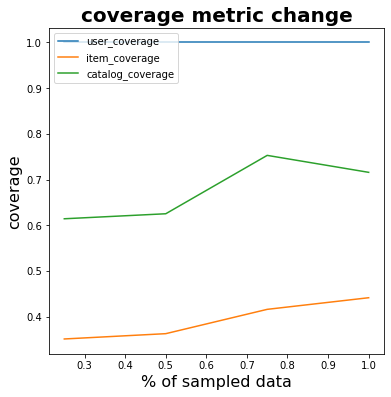

In [273]:
_, ax = plt.subplots(1,1, figsize = (6,6))
ax.plot(frac, user_coverage, label = 'user_coverage')
ax.plot(frac, item_coverage, label = 'item_coverage')
ax.plot(frac, catalog_coverage, label = 'catalog_coverage')
ax.set_title("coverage metric change", fontsize=20, fontweight='bold')
ax.set_xlabel('% of sampled data', fontsize=16)
ax.set_ylabel('coverage', fontsize=16)
ax.legend(loc="upper left", fontsize=10)
plt.show()

#### (3)Scalability

In [274]:
#add plots: runtime vs sample size 

from surprise.model_selection import train_test_split

algo = KNNWithMeans(k=3, sim_options = {'name' : 'pearson', 'user_based' : False}, verbose = False)
frac = [0.25, 0.5, 0.75, 1]
train_time = []
test_time = []
for i in frac:
    subsampled_df = df_sample.sample(frac = i)
    subsampled_df = Dataset.load_from_df(subsampled_df[['userId', 'movieId', 'rating']], reader)
    subsampled_train, subsampled_test = train_test_split(subsampled_df, test_size = 0.2)
    
    start_time = time.time()
    algo.fit(subsampled_train)
    end_time = time.time()
    train_time.append(end_time-start_time)
    
    start_time = time.time()
    pre = algo.test(subsampled_test)
    end_time = time.time()
    test_time.append(end_time-start_time)

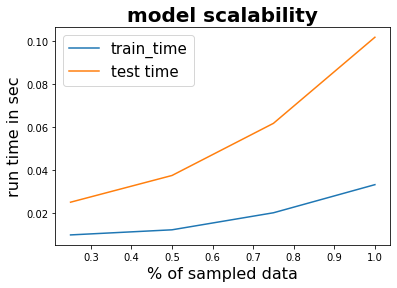

In [276]:
_, ax = plt.subplots(1,1)
ax.plot(frac, train_time, label = 'train_time')
ax.plot(frac, test_time, label = 'test time')
ax.set_title("model scalability", fontsize=20, fontweight='bold')
ax.set_xlabel('% of sampled data', fontsize=16)
ax.set_ylabel('run time in sec', fontsize=16)
ax.legend(loc="best", fontsize=15)
plt.show()

### 2.1.5 Reflection

- Other design choices to consider?

## 2.2 Model-based  Collaborative Filtering

### 2.2.1 Data preprocessing

In [29]:
#initialize spark 
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark ML Basics").getOrCreate()

#process data into dataframe format 
df = spark.read.format('csv').options(header='true').load('./ml-latest/ratings.csv').toDF("userId",  "movieId",  "rating",   "timestamp")

from pyspark.sql.functions import *
from pyspark.sql.types import *


df = df.withColumn("userId", df["userId"].cast(IntegerType())). \
withColumn("movieId", df["movieId"].cast(IntegerType())). \
withColumn("rating",df["rating"].cast(FloatType())). \
withColumn("timestamp", df['timestamp'].cast(LongType()))

In [30]:
#统一下目录，根目录放notebooks、python文件和ml-latest文件夹。

In [31]:
df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3.5|1256677221|
|     1|    481|   3.5|1256677456|
|     1|   1091|   1.5|1256677471|
|     1|   1257|   4.5|1256677460|
|     1|   1449|   4.5|1256677264|
+------+-------+------+----------+
only showing top 5 rows



In [32]:
#sampling data  
sample_df = df.sample(False,0.5,1234)
sample_df.createOrReplaceTempView("sample") 

print('number of users')
spark.sql("select count(1) from (select userId from sample GROUP BY userId)").show()

print('number of itesm')
spark.sql("select count(1) from (select movieId from sample GROUP BY movieId)").show()



number of users
+--------+
|count(1)|
+--------+
|  278413|
+--------+

number of itesm
+--------+
|count(1)|
+--------+
|   46497|
+--------+



In [33]:
#train test split 
train,test=sample_df.randomSplit((0.8,0.2),seed=1234)

### 2.2.2 Model Training

#### basic model

In [34]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)


Root-mean-square error = 0.9030322760116909


In [36]:
#LEYI: 统一个metric？mae, rmse，mse
#model1用的是mase

In [ ]:
#LEYI: can try the implicit ALS model
#als = ALS(maxIter=5, regParam=0.01, implicitPrefs=True,
#           userCol="userId", itemCol="movieId", ratingCol="rating")

### 2.2.3 Model Tuning with Cross validation

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 


paramGrid = ParamGridBuilder() \
    .addGrid(als.maxIter,[5,10,20]) \
    .addGrid(als.regParam, [0.1, 0.01,0.001]) \
    .build()

crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction"),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)


# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)
# selected = prediction.select("id", "text", "probability", "prediction")
# for row in selected.collect():
#     print(row)

In [ ]:
cvModel.avgMetrics

In [ ]:
cvModel.getEstimatorParamMaps()           

### 2.2.4 Model Evaluation

- ROC-based metrics (recall, precision, roc curve, auc)
- DCG
- coverage
- scalability

In [ ]:
#TODO: LEYI

### 2.2.5 Reflection

- Other design choices to consider?

# 3. Final Recommendation

• How does your recommendation system meet your hypothetical objectives? Would you feel comfortable putting these solutions into production at a real company? What would be the potential watch outs?

• What is your final recommendation to your manager?

- Final recommendation to your manager
- Reasons and potential watch outs 